In [13]:
# pip install scikit-learn # wii install scikit-learn as sklearn
# #just import  it as 
# from sklearn.(____) import (----)


#  AI Project 

In [14]:
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms

from torch.autograd import Variable


from PIL import ImageFile
import os
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Source: 

# Downloading Data from amazon udacity

In [15]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

--2022-12-26 11:34:05--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.112
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  58.0MB/s    in 19s     

2022-12-26 11:34:25 (56.2 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]



# # Using Shuttil Libraray to open and extract the zip file to current working directory 

In [16]:
import shutil

filename = "/kaggle/working/dogImages.zip"#/kaggle/working/dogImages.zip
extract_dir = "/kaggle/working/DOGBREEDS"

archive_format = "zip"
shutil.unpack_archive(filename, extract_dir, archive_format)
print("Archive file unpacked successfully.")

Archive file unpacked successfully.


In [17]:
import numpy as np
from glob import glob
dog_files = np.array(glob("/kaggle/working/DOGBREEDS/dogImages/*/*/*"))#/kaggle/working/DOGBREEDS/dogImages
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


# data preprocesssing for VGG model

In [18]:
import os
from torchvision import datasets

# if cuda availabile
use_cuda = torch.cuda.is_available()

# Data preprocessing 
data_preprocess  = { 
    
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), 
            transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                    transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    
    'valid': transforms.Compose([
                transforms.Resize(256),
                    transforms.CenterCrop(224),
                        transforms.ToTensor(),
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
   
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    
}

In [19]:
path = "/kaggle/working/DOGBREEDS/dogImages/"

# Load all pre-processed images
images = {x: datasets.ImageFolder(os.path.join(path, x), data_preprocess[x]) 
          for x in ['train', 'valid', 'test']}

# PyTorch data loading utility has the torch.utils.data.DataLoader class. 
dataloaders = {x: torch.utils.data.DataLoader(images[x], batch_size = 32, shuffle = True, num_workers = 0) 
                for x in ['train', 'valid', 'test']}
# now priniting lengths of three all 
# Lenght of the datasets (train, valid and test)
sizes = {x: len(images[x]) for x in ['train', 'valid', 'test']}

print('Train images: {}'.format(sizes['train']))
print('Valid images: {}'.format(sizes['valid']))
print('Test images: {}'.format(sizes['test']))

Train images: 6680
Valid images: 835
Test images: 836


## Extracting names files

In [20]:
# Get all class names (from train class)
names = images['train'].classes
clean_names = []

# truncating the clear names of breeds from from dog pic names
for name in names:
    clean_names.append(name[4:].replace('_', ' '))

# Identify Number of classes
n_classes = len(clean_names)
print(n_classes)

# for i in range(5):
#     print (clean_names[i])

133


## VGG 16 / 19

In [21]:
class VGG16(nn.Module):
    def __init__(self, num_classes=133):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)#duplicate
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)#duplicate
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
# instantiate the CNN
model_scratch = VGG16()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

## Hyperparameter

In [22]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

testSteps = sizes['test'] // 32
trainSteps = sizes['train'] // 32

VGG_Loss = {"train_loss": [], "test_loss": []}

## Training the model

In [23]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
import time
# t_loss = 0.12
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    since = time.time()
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
       
        # train the model 
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
   
            # zero grad
            optimizer.zero_grad()
            
            # forward pass
            output = model(data)
            
            # batch loss
            loss = criterion(output, target)
            
            # backward pass
            loss.backward()
            
            # optimization step
            optimizer.step()
            
            # training loss
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)
            
            
          
        # validate the model 
       
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
             # forward pass
            output = model(data)
            
            # batch loss
            loss = criterion(output, target)
            
            # average validation loss 
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)
        
        # Training Data
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        #avg loss calc
        
        avg_train_loss = train_loss / trainSteps
        avg_test_loss = valid_loss / testSteps
        print(avg_test_loss)
        VGG_Loss["train_loss"].append(avg_train_loss.cpu().detach().numpy())
        VGG_Loss["test_loss"].append(avg_test_loss.cpu().detach().numpy())
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            print('Validation Loss decreased! Model saved.')
    
    # Elapsed training time
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # return trained model
    return model

In [24]:
# train the model
loaders_scratch = dataloaders

# training on 150 epochs for better accuracy
model_scratch = train(150, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.886909 	Validation Loss: 4.797475
tensor(0.1845, device='cuda:0')
Validation Loss decreased! Model saved.
Epoch: 2 	Training Loss: 4.753763 	Validation Loss: 4.623532
tensor(0.1778, device='cuda:0')
Validation Loss decreased! Model saved.
Epoch: 3 	Training Loss: 4.569016 	Validation Loss: 4.535728
tensor(0.1745, device='cuda:0')
Validation Loss decreased! Model saved.
Epoch: 4 	Training Loss: 4.437296 	Validation Loss: 4.261124
tensor(0.1639, device='cuda:0')
Validation Loss decreased! Model saved.
Epoch: 5 	Training Loss: 4.336009 	Validation Loss: 4.427148
tensor(0.1703, device='cuda:0')
Epoch: 6 	Training Loss: 4.269771 	Validation Loss: 4.095702
tensor(0.1575, device='cuda:0')
Validation Loss decreased! Model saved.
Epoch: 7 	Training Loss: 4.184556 	Validation Loss: 4.019484
tensor(0.1546, device='cuda:0')
Validation Loss decreased! Model saved.
Epoch: 8 	Training Loss: 4.100681 	Validation Loss: 4.008374
tensor(0.1542, device='cuda:0')
Validation Loss 

In [25]:
# Loading a 150 epoch trained model_scratch
model_scratch.load_state_dict(torch.load('/kaggle/working/model_scratch.pt'))

<All keys matched successfully>

## Validtaing Our model

In [71]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss  + ((1 / (batch_idx + 1)) * (loss.data - test_loss)) 
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct +=  t_loss + np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    # testing the loss and printing it
#     print('Test loss is reduced: to {:.6f}'.format(test_loss = test_loss))
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.280529


Test Accuracy: 91% (764/836)


## Losses

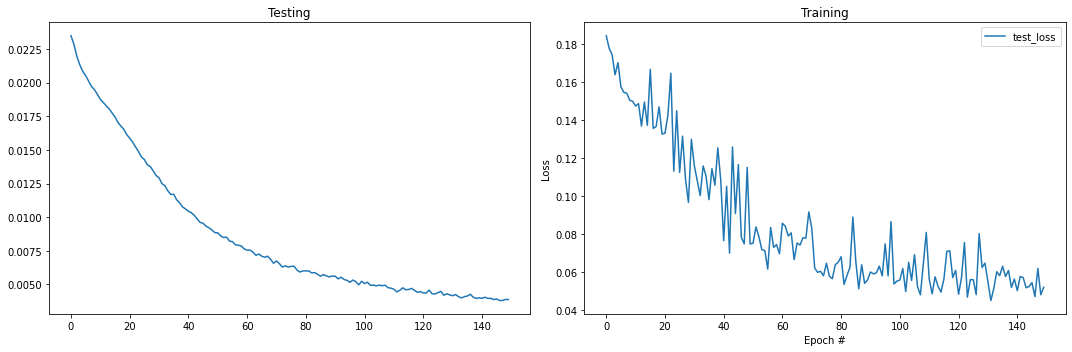

In [48]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axis[1].set_title("Training")
axis[0].set_title("Testing")
axis[0].plot(VGG_Loss["train_loss"], label="train_loss")
axis[1].plot(VGG_Loss["test_loss"], label="test_loss")
# axis[1].plot(CNN_Loss["train_loss"], label="train_loss")
# axis[1].plot(CNN_Loss["test_loss"], label="test_loss")
# plt.plot(VGG_Loss["train_loss"], label="train_loss")
# plt.plot(VGG_Loss["test_loss"], label="test_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

plt.legend(loc="upper right") 
fig.tight_layout()
fig.show()

## Trqnsfer learning

In [78]:
# import torchvision.models as models
# import torch.nn as nn

# model_transfer = models.densenet161(pretrained=True)
# for param in model_transfer.parameters():
#     param.requires_grad = False
# num_ftrs = model_transfer.classifier.in_features
# model_transfer.classifier = nn.Linear(num_ftrs, n_classes)

# if use_cuda:
#     model_transfer.cuda()

In [79]:
# criterion_transfer = nn.CrossEntropyLoss()
# optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01, momentum=0.9)
# loaders_transfer = dataloaders

In [80]:
# # train the model
# n_epochs = 15
# loaders_transfer = dataloaders
# model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

In [81]:
# # Loading a 100 epoch trained model_transfer
# model_transfer.load_state_dict(torch.load('/kaggle/working/model_transfer.pt'))

In [82]:
# test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)


In [ ]:
# import os
# from torchvision import datasets
# import torchvision.transforms as transforms

# ### TODO: Write data loaders for training, validation, and test sets
# ## Specify appropriate transforms, and batch_sizes

# batch_size = 20
# num_workers = 0
# train_dir = "/content/DOGBREEDS/dogImages/train"
# valid_dir = "/content/DOGBREEDS/dogImages/valid"
# test_dir = "/content/DOGBREEDS/dogImages/test"


# standard_normalization = transforms.Normalize(mean=[0.485,0.456,0.406],
#                                               std=[0.299,0.244,0.255])

In [ ]:
# data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.ToTensor(),
#                                      standard_normalization]),
#                    'val': transforms.Compose([transforms.Resize(256),
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor(),
#                                      standard_normalization]),
#                    'test': transforms.Compose([transforms.Resize(size=(224,224)),
#                                      transforms.ToTensor(), 
#                                      standard_normalization])
#                   }

In [ ]:
# train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
# valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
# test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [ ]:
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size=batch_size, 
#                                            num_workers=num_workers,
#                                            shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_data,
#                                            batch_size=batch_size, 
#                                            num_workers=num_workers,
#                                            shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_data,
#                                            batch_size=batch_size, 
#                                            num_workers=num_workers,
#                                            shuffle=False)
# loaders_scratch = {
#     'train': train_loader,
#     'valid': valid_loader,
#     'test': test_loader
# }

In [ ]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# num_classes = 133 # total classes of dog breeds

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F
# import numpy as np

# # define the CNN architecture
# class Net(nn.Module):
#     ### TODO: choose an architecture, and complete the class
#     def __init__(self):
#         super(Net, self).__init__()
#         ## Define layers of a CNN
#         self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

#         # pool
#         self.pool = nn.MaxPool2d(2, 2)
        
#         # fully-connected
#         self.fc1 = nn.Linear(7*7*128, 500)
#         self.fc2 = nn.Linear(500, num_classes) 
        
#         # drop-out
#         self.dropout = nn.Dropout(0.3)
    
#     def forward(self, x):
#         ## Define forward behavior
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = F.relu(self.conv3(x))
#         x = self.pool(x)
        
#         # flatten
#         x = x.view(-1, 7*7*128)
        
#         x = self.dropout(x)
#         x = F.relu(self.fc1(x))
        
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# #-#-# You so NOT have to modify the code below this line. #-#-#

# # instantiate the CNN
# model_scratch = Net()
# print(model_scratch)

# # move tensors to GPU if CUDA is available
# if use_cuda:
#     model_scratch.cuda()

In [ ]:
# import torch.optim as optim

# ### TODO: select loss function
# criterion_scratch = nn.CrossEntropyLoss()

# ### TODO: select optimizer
# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

---